https://discourse.julialang.org/t/solve-ode-with-many-different-initial-conditions/66384

In [1]:
using DifferentialEquations
using StaticArrays
using Base.Threads
using PyPlot
using Parameters

In [2]:
# define system parameters
Ip = 0.5
N  = 2
w  = 0.057
T  = 2π/w
F0 = 0.075
a = 1.0

# combine the system parameters into a single variable
p = (; Ip, N, w, T, F0, a,)

# define laser pulse
function Fx(p, t)
    @unpack F0, N, w, T = p
    F0 * cos(w*t/(2N))^2 * cos(w*t) * (abs(t) < N*T/2)
end
function Fy(p, t)
    @unpack F0, N, w, T = p
    F0 * cos(w*t/(2N))^2 * sin(w*t) * (abs(t) < N*T/2)
end

# define electron trajectory
function traj(u, p, t)
    @unpack a = p
    r3i = (u[1]^2 + u[2]^2 + a)^(-1.5)
    du1 = u[3]
    du2 = u[4]
    du3 = -u[1]*r3i - Fx(p, t)
    du4 = -u[2]*r3i - Fy(p, t)
    SVector(du1, du2, du3, du4)
end

# define rate
function W_adk(p, F, kd)
    @unpack Ip = p
    exp(-(2.0*(kd^2+2Ip)^1.5)/3F)
end

# define result box
Px  = range(-2, 2, length = 200)
Py  = range(-2, 2, length = 200)
    
# define simulation parameters
simparam = (
    Nt = 500,
    Nkd = 100,
    kd_max = 2.0,
)

(Nt = 500, Nkd = 100, kd_max = 2.0)

In [3]:
function calcprob(p, Px, Py, simparam)
    @unpack Ip, N, w, T, F0, a = p
    Px_num, dPx = length(Px), step(Px)
    Py_num, dPy = length(Py), step(Py)
    @unpack Nt, Nkd, kd_max = simparam
    
    Prob_nthreads = zeros(Px_num, Py_num, nthreads())
    Trajs = [ODEProblem(traj, @SVector(zeros(4)), (-N*T/2, N*T/2), p) for _ in 1:nthreads()]
    
    @threads for tr in range(-0.9N*T/2, 0.9N*T/2, length = Nt)
        tid = threadid()
        Fxtr = Fx(p, tr)
        Fytr = Fy(p, tr)
        Ftr = hypot(Fxtr, Fytr)
        phi = atan(-Fytr, -Fxtr)
        r0 = Ip/Ftr
        x0 = r0*cos(phi)
        y0 = r0*sin(phi)
        tspan = (tr, N*T/2)
        
        for kd in range(-kd_max, kd_max, length = Nkd)
            kx0 = kd*cos(phi + 0.5π)
            ky0 = kd*sin(phi + 0.5π)
            rate = W_adk(p, Ftr, kd)

            u0 = SVector(x0, y0, kx0, ky0)
            Traj = remake(Trajs[tid]; u0=u0, tspan=tspan)
            sol = solve(Traj, Tsit5(), reltol=1e-6, save_everystep=false, save_start=false)
            (x, y, px, py) = sol.u[end]

            E_inf = 0.5*(px^2 + py^2) - 1/(x^2 + y^2 + a)
            E_inf >= zero(E_inf) || continue
            pxidx = round(Int, (px - Px[1])/dPx) + 1
            pyidx = round(Int, (py - Py[1])/dPy) + 1
            checkbounds(Bool, Prob_nthreads, pxidx, pyidx, tid) || continue
            @inbounds Prob_nthreads[pxidx, pyidx, tid] += rate
        end
    end
    Prob = reshape(sum(Prob_nthreads, dims=3), size(Prob_nthreads)[1:2])
end

calcprob (generic function with 1 method)

In [4]:
# plotting
function plotprob(Px, Py, Prob)
    fig, ax = plt.subplots()
    ax.imshow(Prob', extent=(Px[1], Px[end], Py[1], Py[end]), origin="lower")
    ax.set_xlim(Px[1], Px[end])
    ax.set_ylim(Py[1], Py[end])
    ax.set_xlabel("\$p_x\$ (a.u.)")
    ax.set_ylabel("\$p_y\$ (a.u.)")
    #plt.show()
end

plotprob (generic function with 1 method)

  4.674843 seconds (14.10 M allocations: 946.903 MiB, 4.23% gc time, 96.75% compilation time)
  0.204111 seconds (1.00 M allocations: 155.970 MiB, 19.95% gc time)
  0.146866 seconds (1.00 M allocations: 155.970 MiB)


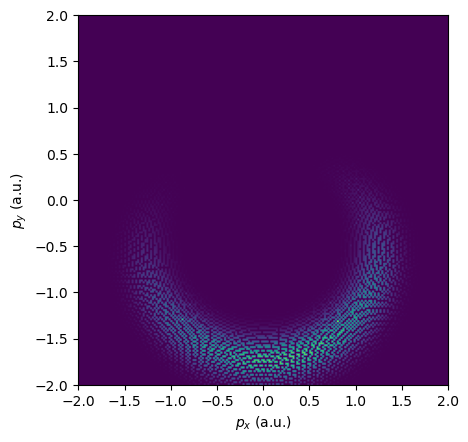

PyObject Text(29.299999999999997, 0.5, '$p_y$ (a.u.)')

In [5]:
@time Prob = calcprob(p, Px, Py, simparam)
@time Prob = calcprob(p, Px, Py, simparam)
@time Prob = calcprob(p, Px, Py, simparam)
flush(stdout)
plotprob(Px, Py, Prob)